In [1]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *
from MPRA_predict.metrics import *

In [2]:
MPRA_df = pd.read_csv('../data/GosaiMPRA/GosaiMPRA_my_processed_data_len200_norm.csv')
MPRA_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.014,-0.054,0.012,NaN,-0.709
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-1.042,0.183,0.094,NaN,-0.266
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-1.004,0.640,-0.188,NaN,0.619
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.779,0.751,0.274,NaN,0.668
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.457,-0.645,0.061,NaN,-0.168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760674,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,NaN,NaN,NaN,OL15,OL15,0.708,1.294,1.077,NaN,NaN
760675,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,NaN,NaN,NaN,OL15,OL15,-0.708,-0.547,-0.429,NaN,NaN
760676,TGTTCAAGTGGCCACAGGGTTACTTGCTTTAGCATGGCTCCTTGGC...,Y:21740884:NA:NA,chrY,21740884,NaN,NaN,NaN,OL15,OL15,-0.146,-0.200,-0.310,NaN,NaN
760677,TAATTAGTTGGGAAGGTTCAGGTTCTGGGACATCCGTTGCTATTTC...,Y:21741084:NA:NA,chrY,21741084,NaN,NaN,NaN,OL15,OL15,-0.119,-0.090,-0.387,NaN,NaN


In [4]:
MPRA_UPSTREAM  = 'ACGAAAATGTTGGATGCTCATACTCGTCCTTTTTCAATATTATTGAAGCATTTATCAGGGTTACTAGTACGTCTCTCAAGGATAAGTAAGTAATATTAAGGTACGGGAGGTATTGGACAGGCCGCAATAAAATATCTTTATTTTCATTACATCTGTGTGTTGGTTTTTTGTGTGAATCGATAGTACTAACATACGCTCTCCATCAAAACAAAACGAAACAAAACAAACTAGCAAAATAGGCTGTCCCCAGTGCAAGTGCAGGTGCCAGAACATTTCTCTGGCCTAACTGGCCGCTTGACG'
MPRA_DOWNSTREAM= 'CACTGCGGCTCCTGCGATCTAACTGGCCGGTACCTGAGCTCGCTAGCCTCGAGGATATCAAGATCTGGCCTCGGCGGCCAAGCTTAGACACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCCGGTACTGTTGGTAAAGCCACCATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCT'
MPRA_df['seq_800'] = MPRA_UPSTREAM + MPRA_df['seq'] + MPRA_DOWNSTREAM
MPRA_df.to_csv('../data/GosaiMPRA/GosaiMPRA_my_processed_data_len800.csv', index=False)

In [3]:
# feature_matrix = np.load('Sei_Siraj_pred_feature_matrix.npy')
# feature_matrix = np.load('GosaiMPRA_Sei_pred_feature_matrix.npy')
feature_matrix = load_h5('outputs/GosaiMPRA_Borzoi_feature_matrix.h5')
feature_matrix.shape

(760679, 5, 8)

In [4]:
data_split_dict = {}
data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)
data_split_dict['chrom'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(1, 23)) + ['X', 'Y'])])
data_split_dict['designed'] = ~data_split_dict['chrom']

data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(3, 23)) + ['X', 'Y'])])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test'] = MPRA_df['chr'].isin(['chr2'])

data_split_dict['ref'] = (MPRA_df['allele'] == 'ref') | (MPRA_df['allele'].isna())
data_split_dict['alt'] = MPRA_df['allele'] == 'alt'

In [5]:
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'CTCF']
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']

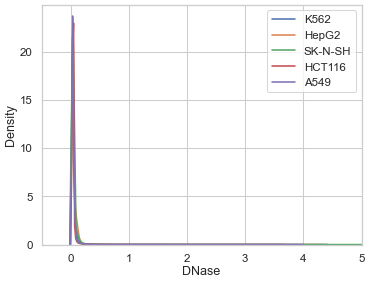

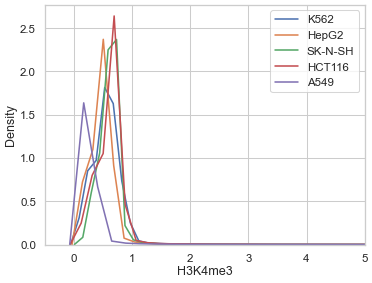

/tmp/ipykernel_5897/3067513879.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)
/tmp/ipykernel_5897/3067513879.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)
/tmp/ipykernel_5897/3067513879.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


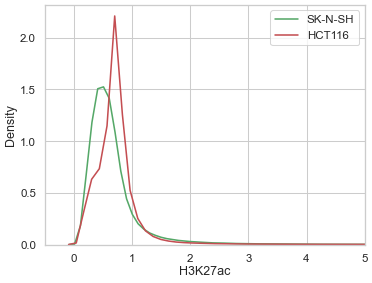

/tmp/ipykernel_5897/3067513879.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


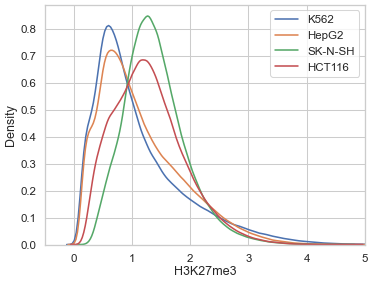

/tmp/ipykernel_5897/3067513879.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


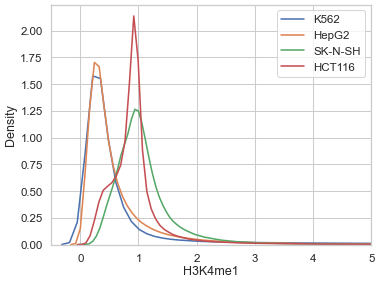

/tmp/ipykernel_5897/3067513879.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


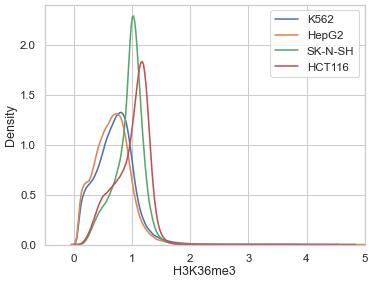

/tmp/ipykernel_5897/3067513879.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


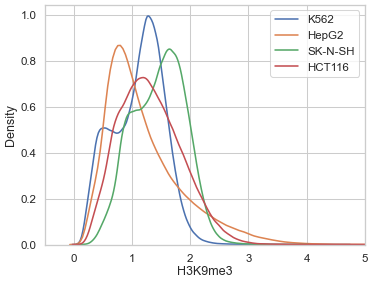

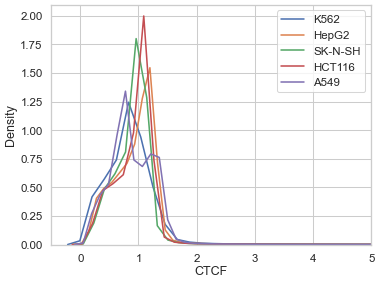

In [7]:
for j, assay in enumerate(assays):
    plt.figure(figsize=(8, 6), dpi=50)
    plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
    for i, cell_type in enumerate(cell_types):
        x = feature_matrix[:, i, j]
        sns.kdeplot(x, label=cell_type)
    plt.xlim(-0.5, 5)
    plt.xlabel(f'{assay}')
    plt.legend()
    plt.savefig(f'figures/kde_Borzoi_{assay}_distribution.png', dpi=400)
    plt.show()

In [21]:
# normalize between different cell types and assays



# feature_matrix_norm = np.full_like(feature_matrix, np.nan)

# for i, cell_type in enumerate(cell_types):
#     for j, assay in enumerate(assays):
#         x = feature_matrix[:, i, j]
#         condition = data_split_dict['train']
#         x_mean = np.mean(x[condition])
#         x_std = np.std(x[condition])
#         x = (x - x_mean) / x_std
#         feature_matrix_norm[:, i, j] = x




feature_matrix_norm = np.full_like(feature_matrix, np.nan)

for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        x = feature_matrix[:, i, j]
        condition = data_split_dict['train']
        x_train = x[condition]
        # threshold = np.percentile(x_train, 95)
        # x_train_clipped = x_train[x_train <= threshold]
        # x_std = np.sum(x_train_clipped ** 2) # 去除极端值求方差
        # x = x / x_std
        x_median = np.median(x_train)
        x = x/ x_median
        feature_matrix_norm[:, i, j] = x

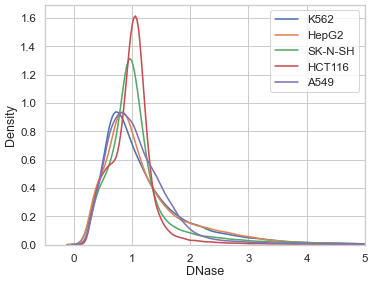

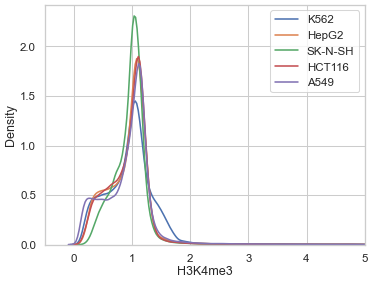

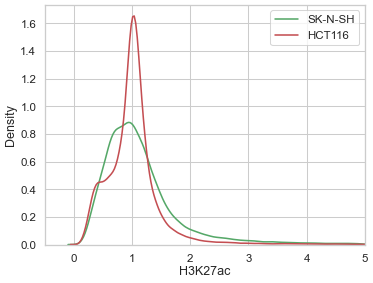

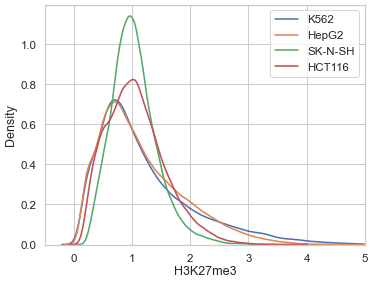

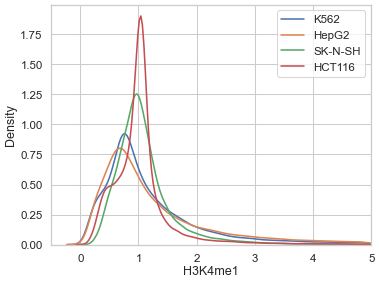

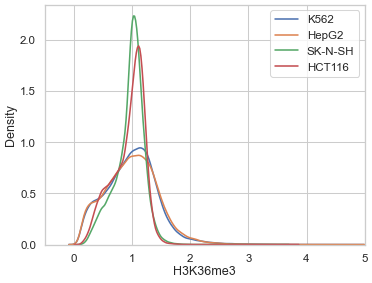

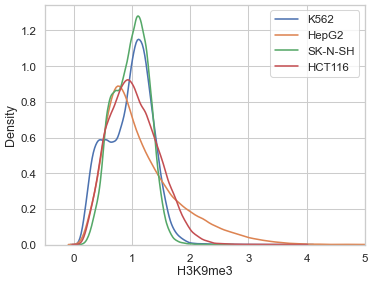

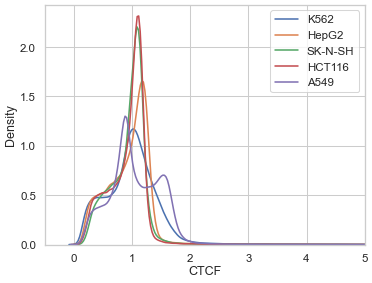

In [24]:
for j, assay in enumerate(assays):
    plt.figure(figsize=(8, 6), dpi=50)
    plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
    for i, cell_type in enumerate(cell_types):
        x = feature_matrix_norm[:, i, j]
        x = x[x <= 5]
        sns.kdeplot(x[:100000], label=cell_type)
    plt.xlim(-0.5, 5)
    plt.xlabel(f'{assay}')
    plt.legend()
    plt.savefig(f'figures/kde_Borzoi_{assay}_norm_distribution.png', dpi=400)
    plt.show()

In [25]:
# normalize exp between different cell types
MPRA_df_norm = MPRA_df.copy()

for i, cell_type in enumerate(cell_types):
    x = MPRA_df[cell_type].copy()
    condition = data_split_dict['train']
    x_mean = np.mean(x[condition])
    x_std = np.std(x[condition])
    x = (x - x_mean) / x_std
    MPRA_df_norm[cell_type] = x

In [26]:
MPRA_df_norm

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.014,-0.054,0.012,NaN,-0.709
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-1.042,0.183,0.094,NaN,-0.266
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-1.004,0.640,-0.188,NaN,0.619
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.779,0.751,0.274,NaN,0.668
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.457,-0.645,0.061,NaN,-0.168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760674,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,NaN,NaN,NaN,OL15,OL15,0.708,1.294,1.077,NaN,NaN
760675,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,NaN,NaN,NaN,OL15,OL15,-0.708,-0.547,-0.429,NaN,NaN
760676,TGTTCAAGTGGCCACAGGGTTACTTGCTTTAGCATGGCTCCTTGGC...,Y:21740884:NA:NA,chrY,21740884,NaN,NaN,NaN,OL15,OL15,-0.146,-0.200,-0.310,NaN,NaN
760677,TAATTAGTTGGGAAGGTTCAGGTTCTGGGACATCCGTTGCTATTTC...,Y:21741084:NA:NA,chrY,21741084,NaN,NaN,NaN,OL15,OL15,-0.119,-0.090,-0.387,NaN,NaN


In [28]:
for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        MPRA_df_norm[f'{cell_type}_{assay}'] = feature_matrix_norm[:, i, j]

MPRA_df_norm

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF,SK-N-SH_DNase,SK-N-SH_H3K4me3,SK-N-SH_H3K27ac,SK-N-SH_H3K27me3,SK-N-SH_H3K4me1,SK-N-SH_H3K36me3,SK-N-SH_H3K9me3,SK-N-SH_CTCF,HCT116_DNase,HCT116_H3K4me3,HCT116_H3K27ac,HCT116_H3K27me3,HCT116_H3K4me1,HCT116_H3K36me3,HCT116_H3K9me3,HCT116_CTCF,A549_DNase,A549_H3K4me3,A549_H3K27ac,A549_H3K27me3,A549_H3K4me1,A549_H3K36me3,A549_H3K9me3,A549_CTCF
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.014,-0.054,0.012,NaN,-0.709,2.461,1.664,NaN,5.367,6.263,1.203,1.275,1.661,2.706,1.081,NaN,2.951,1.747,1.691,0.947,1.154,2.424,1.241,1.993,1.848,1.829,1.032,1.090,1.186,1.077,1.108,1.377,1.780,1.123,1.016,0.937,1.110,1.651,1.244,NaN,NaN,NaN,NaN,NaN,1.698
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-1.042,0.183,0.094,NaN,-0.266,2.606,1.707,NaN,5.620,7.605,1.155,1.247,1.681,2.728,1.099,NaN,2.888,1.886,1.810,0.897,1.138,2.756,1.273,2.335,1.939,2.104,1.013,1.001,1.201,1.049,1.116,1.392,1.857,1.120,0.993,0.883,1.110,1.676,1.274,NaN,NaN,NaN,NaN,NaN,1.710
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-1.004,0.640,-0.188,NaN,0.619,1.080,1.091,NaN,1.322,0.963,1.217,1.395,1.141,1.288,1.182,NaN,1.454,1.172,1.150,2.112,1.177,0.924,1.243,2.291,1.109,1.337,1.156,1.388,1.181,1.441,1.303,1.184,1.310,1.346,1.265,1.767,1.145,1.727,1.259,NaN,NaN,NaN,NaN,NaN,1.325
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.779,0.751,0.274,NaN,0.668,1.069,1.090,NaN,1.240,1.019,1.202,1.383,1.133,1.281,1.213,NaN,1.402,1.417,1.166,2.180,1.192,0.909,1.241,2.722,1.069,1.404,1.180,1.401,1.193,1.514,1.303,1.248,1.243,1.389,1.304,1.764,1.155,1.969,1.347,NaN,NaN,NaN,NaN,NaN,1.303
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.457,-0.645,0.061,NaN,-0.168,0.759,1.099,NaN,0.919,0.717,1.021,1.189,1.054,1.003,1.198,NaN,0.953,1.002,0.961,1.330,1.116,1.105,1.022,1.351,1.048,1.134,1.056,1.323,1.025,1.054,1.121,1.008,1.642,1.102,1.203,1.309,1.148,0.766,1.108,NaN,NaN,NaN,NaN,NaN,0.886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760674,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,NaN,NaN,NaN,OL15,OL15,0.708,1.294,1.077,NaN,NaN,3.801,1.784,NaN,3.131,22.514,2.324,1.019,2.137,3.565,1.424,NaN,2.173,3.869,2.271,0.617,1.467,4.904,1.743,1.050,2.066,1.463,1.070,0.931,1.542,1.569,1.327,1.877,1.193,1.824,1.090,0.821,1.295,2.139,1.383,NaN,NaN,NaN,NaN,NaN,2.042
760675,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,NaN,NaN,NaN,OL15,OL15,-0.708,-0.547,-0.429,NaN,NaN,1.249,1.085,NaN,1.199,0.994,1.161,1.201,1.134,1.161,1.110,NaN,1.276,1.147,1.016,1.137,1.101,1.373,1.089,1.833,1.023,1.776,1.092,1.091,1.133,1.164,1.157,1.069,1.461,1.277,1.146,1.280,1.085,1.232,1.147,NaN,NaN,NaN,NaN,NaN,1.105
760676,TGTTCAAGTGGCCACAGGGTTACTTGCTTTAGCATGGCTCCTTGGC...,Y:21740884:NA:NA,chrY,21740884,NaN,NaN,NaN,OL15,OL15,-0.146,-0.200,-0.310,NaN,NaN,0.927,0.839,NaN,0.896,0.503,0.838,1.102,0.905,1.176,0.862,NaN,1.071,1.315,0.742,1.797,0.976,1.235,1.029,1.263,1.057,0.967,0.911,1.112,0.985,1.365,0.933,0.863,1.163,0.916,0.952,1.255,0.951,1.842,1.077,NaN,NaN,NaN,NaN,NaN,0.875
760677,TAATTAGTTGGGAAGGTTCAGGTTCTGGGACATCCGTTGCTATTTC...,Y:21741084:NA:NA,chrY,21741084,NaN,NaN,NaN,OL15,OL15,-0.119,-0.090,-0.387,NaN,NaN,0.984,0.930,NaN,0.771,0.732,1.179,1.265,1.029,1.128,1.113,NaN,1.353,0.886,1.203,1.592,1.152,1.251,1.062,1.465,0.972,1.

In [29]:
MPRA_df_norm.to_csv('../data/GosaiMPRA/GosaiMPRA_Borzoi_feature_norm.csv', index=False)

In [ ]:
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']

for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        MPRA_df_norm[f'{cell_type}_{assay}'] = feature_matrix_norm[:, i, j]

In [ ]:
MPRA_df_norm

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_CTCF,SK-N-SH_DNase,SK-N-SH_H3K4me3,SK-N-SH_H3K27ac,SK-N-SH_CTCF,A549_DNase,A549_H3K4me3,A549_H3K27ac,A549_CTCF,HCT116_DNase,HCT116_H3K4me3,HCT116_H3K27ac,HCT116_CTCF
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.014,-0.054,0.012,NaN,-0.709,1.386,2.063,1.868,1.566,1.225,1.827,1.603,1.333,1.134,1.738,1.171,1.208,1.076,2.014,1.676,1.396,0.886,1.952,1.559,1.342
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-1.042,0.183,0.094,NaN,-0.266,1.408,2.095,1.866,1.543,1.231,1.851,1.607,1.300,1.201,1.838,1.256,1.199,1.080,2.074,1.721,1.373,0.891,1.988,1.591,1.314
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-1.004,0.640,-0.188,NaN,0.619,0.428,0.468,0.047,0.242,1.231,1.236,1.085,0.644,-0.111,1.132,1.520,0.533,1.583,1.167,0.820,0.513,1.144,0.694,0.951,0.439
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.779,0.751,0.274,NaN,0.668,0.538,0.649,0.237,0.292,1.238,1.419,1.228,0.643,0.061,1.472,1.909,0.636,1.605,1.406,1.053,0.538,1.135,0.827,1.080,0.462
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.457,-0.645,0.061,NaN,-0.168,-0.900,-0.815,-0.628,-0.986,-0.987,-0.688,-0.799,-1.136,-1.086,-0.642,-0.376,-1.034,-1.133,-0.800,-0.735,-1.089,-0.985,-0.945,-0.740,-0.956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760674,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,NaN,NaN,NaN,OL15,OL15,0.708,1.294,1.077,NaN,NaN,2.335,2.768,2.025,1.701,2.188,2.653,1.884,1.501,3.210,3.555,2.518,2.075,2.388,3.118,2.803,1.672,2.150,3.154,2.291,1.409
760675,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,NaN,NaN,NaN,OL15,OL15,-0.708,-0.547,-0.429,NaN,NaN,-0.439,-0.699,-0.556,-0.701,-0.477,-0.811,-0.667,-0.663,0.434,-0.690,-0.614,-0.350,-0.396,-0.853,-0.733,-0.638,-0.584,-0.885,-0.767,-0.700
760676,TGTTCAAGTGGCCACAGGGTTACTTGCTTTAGCATGGCTCCTTGGC...,Y:21740884:NA:NA,chrY,21740884,NaN,NaN,NaN,OL15,OL15,-0.146,-0.200,-0.310,NaN,NaN,0.030,-0.160,0.350,-0.132,0.555,0.219,0.730,0.256,0.583,0.169,1.307,0.353,1.262,0.911,1.405,0.309,0.869,0.180,0.969,0.098
760677,TAATTAGTTGGGAAGGTTCAGGTTCTGGGACATCCGTTGCTATTTC...,Y:21741084:NA:NA,chrY,21741084,NaN,NaN,NaN,OL15,OL15,-0.119,-0.090,-0.387,NaN,NaN,0.130,-0.181,0.024,-0.370,-0.089,-0.368,-0.322,-0.222,1.671,-0.317,-0.035,0.272,0.068,-0.781,-0.523,-0.264,0.158,-0.410,-0.294,-0.416


In [ ]:
# MPRA_df_norm.to_csv('../data/SirajMPRA/SirajMPRA_562654_0317.csv', index=False)
MPRA_df_norm.to_csv('../data/GosaiMPRA/GosaiMPRA_epi_norm.csv', index=False)

In [ ]:
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'CTCF']

data_split_dict = {}
data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)
data_split_dict['chrom'] = MPRA_df['chr'].isin([f'chr{i}' for i in range(1, 23)])
data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in range(3, 23)])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test'] = MPRA_df['chr'].isin(['chr2'])
data_split_dict['designed'] = MPRA_df['chr'].isin(['chr0'])

data_split_dict['ref'] = MPRA_df['is_ref']
data_split_dict['alt'] = ~MPRA_df['is_ref']

# stds = MPRA_df[cell_types].std(axis=1, skipna=True)
# threshold = np.percentile(stds.dropna(), 90)
# data_split_dict['diff'] = (stds > threshold)
# data_split_dict['const'] = ~data_split_dict['diff']

# main_df['diff'] = (main_df[cell_types].max(axis=1) - main_df[cell_types].min(axis=1)) > 1
# data_split_dict['const'] = ~main_df['diff']
# data_split_dict['diff']  = main_df['diff']

# keys = list(data_split_dict.keys())
# for k1 in keys:
#     for k2 in keys:
#         data_split_dict[f'{k1}_{k2}'] = data_split_dict[k1] & data_split_dict[k2]

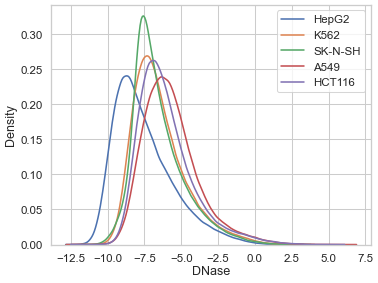

/tmp/ipykernel_80640/113565512.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


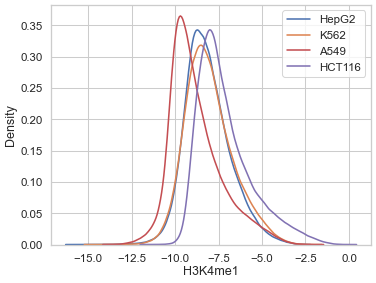

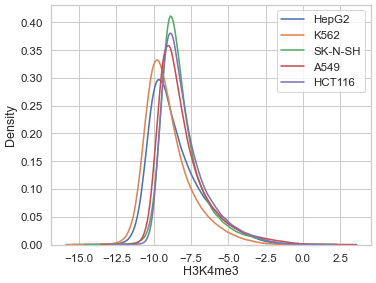

/tmp/ipykernel_80640/113565512.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


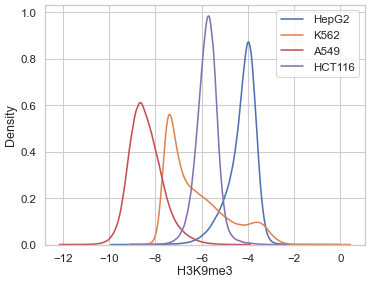

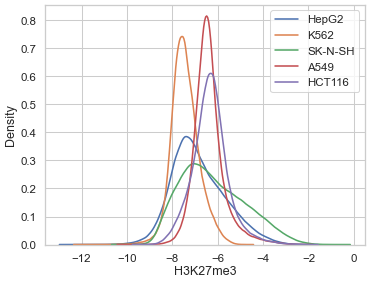

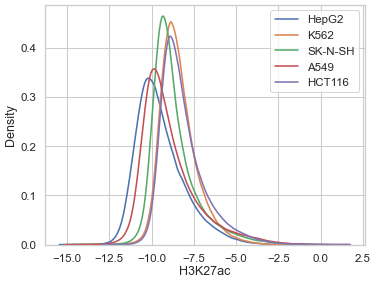

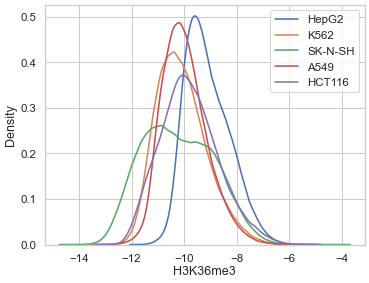

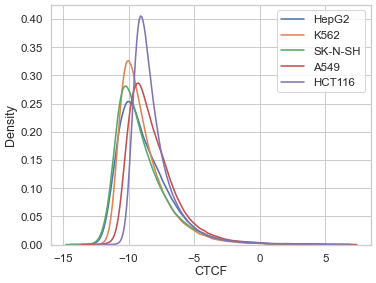

In [ ]:
for j, assay in enumerate(assays):
    plt.figure(figsize=(8, 6), dpi=50)
    plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
    for i, cell_type in enumerate(cell_types):
        x = feature_matrix[:, i, j]
        sns.kdeplot(x, label=cell_type)
    plt.xlabel(f'{assay}')
    plt.legend()
    plt.show()

In [ ]:
# normalize between different cell types

feature_matrix_norm = np.full_like(feature_matrix, np.nan)

for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        x = feature_matrix[:, i, j]
        condition = data_split_dict['train']
        x_mean = np.mean(x[condition])
        x_std = np.std(x[condition])
        x = (x - x_mean) / x_std
        feature_matrix_norm[:, i, j] = x

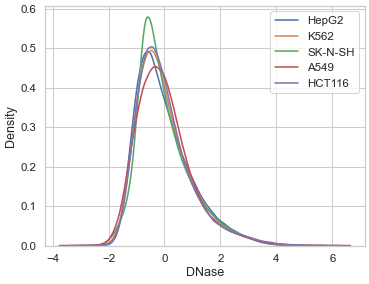

/tmp/ipykernel_80640/2171355260.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


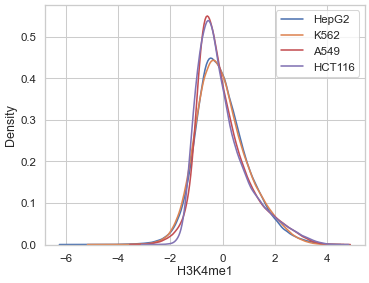

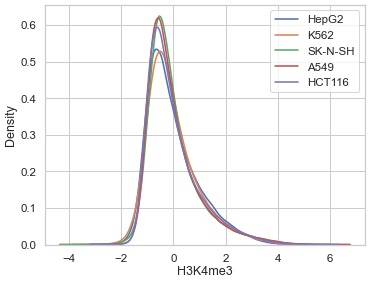

/tmp/ipykernel_80640/2171355260.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


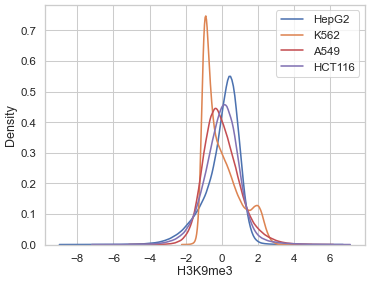

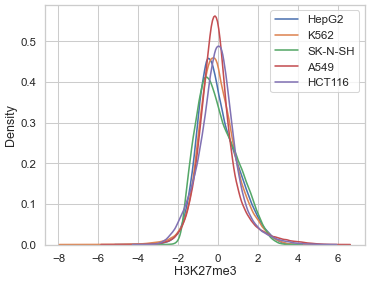

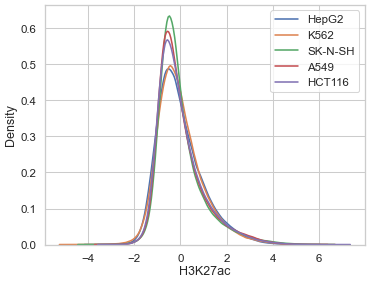

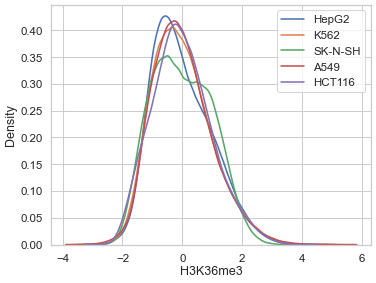

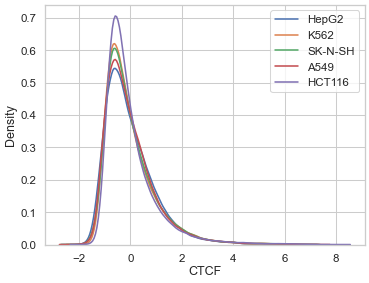

In [ ]:
for j, assay in enumerate(assays):
    plt.figure(figsize=(8, 6), dpi=50)
    plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
    for i, cell_type in enumerate(cell_types):
        x = feature_matrix_norm[:, i, j]
        sns.kdeplot(x, label=cell_type)
    plt.xlabel(f'{assay}')
    plt.legend()
    plt.show()

In [ ]:
np.save('Sei_Siraj_feature_matrix_norm.npy', feature_matrix_norm)

In [ ]:
MPRA_df = pd.read_csv('../data/SirajMPRA/SirajMPRA_562654.csv')
MPRA_df

,description,seq,A549,HepG2,K562,SK-N-SH,HCT116,is_ref,chr,pos,ref,alt,start,end,585605_index
0,chr1:14677:G:A,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,NaN,0.668,-0.704,0.539,0.159,True,chr1,14677,G,A,14577,14777,0
1,chr1:14677:G:A,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,NaN,0.416,0.554,0.442,-0.288,False,chr1,14677,G,A,14577,14777,1
2,chr1:63697:T:C,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,NaN,1.270,-0.391,0.752,1.100,True,chr1,63697,T,C,63597,63797,2
3,chr1:63697:T:C,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,NaN,1.152,-0.659,0.205,1.051,False,chr1,63697,T,C,63597,63797,3
4,chr1:64764:C:T,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,NaN,-0.211,-0.007,0.499,0.258,True,chr1,64764,C,T,64664,64864,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562649,chrX:155233098:T:C,ATCATTTACTGGTGACTGCCCTGCTAGGGTGTCAGCTGTCAGATCC...,NaN,0.616,1.927,0.798,1.035,False,chrX,155233098,T,C,155232998,155233198,585600
562650,chrX:155233794:A:G,TGGTTACTGCAGGGGCAGGGTTTTGGCAGGAAATAAACATGCACGG...,NaN,1.410,0.556,2.843,1.496,True,chrX,155233794,A,G,155233694,155233894,585601
562651,chrX:155233794:A:G,TGGTTACTGCAGGGGCAGGGTTTTGGCAGGAAATAAACATGCACGG...,NaN,0.895,-0.073,1.974,0.795,False,chrX,155233794,A,G,155233694,155233894,585602
562652,chrX:155234730:T:C,TGGTGAGTTGCTTCTGTGCACACACTTTTGTTTATGAGTGTGCATG...,NaN,0.312,0.166,-0.041,0.444,True,chrX,155234730,T,C,155234630,155234830,585603


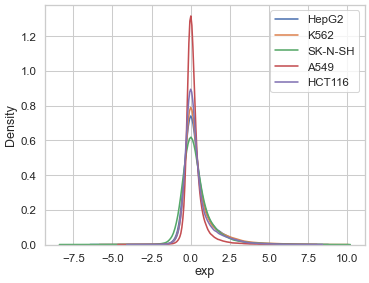

In [ ]:
plt.figure(figsize=(8, 6), dpi=50)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
for i, cell_type in enumerate(cell_types):
    x = MPRA_df[cell_type]
    sns.kdeplot(x, label=cell_type)
plt.xlabel(f'exp')
plt.legend()
plt.show()

In [ ]:
# normalize between different cell types
MPRA_df_norm = MPRA_df.copy()

for i, cell_type in enumerate(cell_types):
    x = MPRA_df[cell_type].copy()
    condition = data_split_dict['train']
    x_mean = np.mean(x[condition])
    x_std = np.std(x[condition])
    x = (x - x_mean) / x_std
    MPRA_df_norm[cell_type] = x

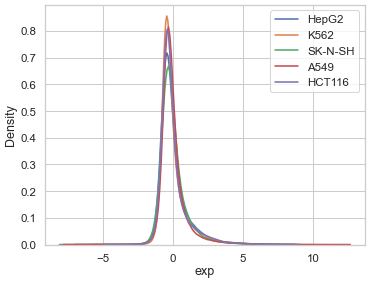

In [ ]:
plt.figure(figsize=(8, 6), dpi=50)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)
for i, cell_type in enumerate(cell_types):
    x = MPRA_df_norm[cell_type]
    sns.kdeplot(x, label=cell_type)
plt.xlabel(f'exp')
plt.legend()
plt.show()

In [ ]:
MPRA_df_norm.to_csv('../data/SirajMPRA/SirajMPRA_562654_norm.csv', index=False)